In [1]:
print("Hello world!")

Hello world!


In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, f1_score, accuracy_score, classification_report, confusion_matrix, make_scorer, recall_score
from sklearn.svm import SVC
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN
from tabulate import tabulate

In [3]:
X_nt = pd.read_csv("C:\Aniruddh\Python\Jupyter\RCC\CSV FILES\Cleaned data\RCC_non_test_set.csv", index_col = 0)
X_t = pd.read_csv("C:\Aniruddh\Python\Jupyter\RCC\CSV FILES\Cleaned data\RCC_test_set.csv", index_col = 0)
X = pd.concat([X_nt, X_t])
y = X.pop('RECURRENCE')
y_nt = X_nt.pop("RECURRENCE")
y_t = X_t.pop("RECURRENCE")

In [4]:
X_nt.isna().sum().sum()

8

In [5]:
X_t.loc[X_t.LOW.isna(), 'LOW'] = 0

In [6]:
# VANILLA/NORMAL
scaler = StandardScaler()
imputer = SimpleImputer(strategy = 'median')
svm1 = SVC(random_state = 42)
pipelineN1 = Pipeline([
    ('imputer', imputer),
    ('scaler', scaler),
    ('svm', svm1)
])

In [7]:
pipelineN1.fit(X_nt, y_nt)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('svm', SVC(random_state=42))])

In [8]:
# CREATE 4 TRACKS: NORMAL, RESAMPLE, SMOTE AND ADASYN

In [9]:
# RESAMPLE
imputer_r = SimpleImputer(strategy = 'constant', fill_value = 0)
scaler_r = StandardScaler()
X_nt_s_i = scaler_r.fit_transform(imputer_r.fit_transform(X_nt))
X_t_s_i = scaler_r.transform(imputer_r.transform(X_t))
majority_X_nt = X_nt_s_i[y_nt == 0]
minority_X_nt = X_nt_s_i[y_nt == 1]
majority_y_nt = y_nt[y_nt == 0]
minority_y_nt = y_nt[y_nt == 1]
oversampled_X_min, oversampled_y_min = resample(minority_X_nt, minority_y_nt, replace = True, n_samples = len(majority_X_nt), random_state = 42)
X_nt_ov = np.concatenate((majority_X_nt, oversampled_X_min))
y_nt_ov = np.concatenate((majority_y_nt, oversampled_y_min))

In [10]:
y_nt_ov.shape

(848,)

In [11]:
# SMOTE: NEEDS PREPROCESSING
# smote = SMOTE(random_state = 42)
# X_nt_smote, y_nt_smote = smote.fit_resample(X_nt, y_nt)

In [12]:
# ADASYN: NEEDS PREPROCESSING
# adasyn = ADASYN(random_state = 42)
# X_nt_adasyn, y_nt_adasyn = adasyn.fit_resample(X_nt, y_nt)

In [13]:
def grid_searcher(param_grid, pipeline, scoring = 'recall', X_nt = X_nt, y_nt = y_nt, cv = 5, verbose = 1):
    tic = time.time()
    grid_search = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = cv, scoring = scoring, n_jobs = -1, verbose = verbose)
    grid_search.fit(X_nt, y_nt)
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    best_model = grid_search.best_estimator_
    toc = time.time()
    print("Time Taken:", toc - tic)
    return best_params, best_model

In [81]:
def model_test(best_model, X_t = X_t, y_t = y_t):
    y_pred_test = best_model.predict(X_t)
    class_names = ['Class 0', 'Class 1']
    report_test = classification_report(y_t, y_pred_test, target_names = class_names)
    print("Classification Report on Test Set:")
    print(report_test)
    cm = confusion_matrix(y_t, y_pred_test)
    cm_table = tabulate(cm, headers=class_names, tablefmt='grid')
    print("Confusion Matrix:")
    print(cm_table)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

C:\Users\aniru\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\aniru\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\aniru\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.88      1.00      0.93       183
     Class 1       0.00      0.00      0.00        26

    accuracy                           0.88       209
   macro avg       0.44      0.50      0.47       209
weighted avg       0.77      0.88      0.82       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       183 |         0 |
+-----------+-----------+
|        26 |         0 |
+-----------+-----------+


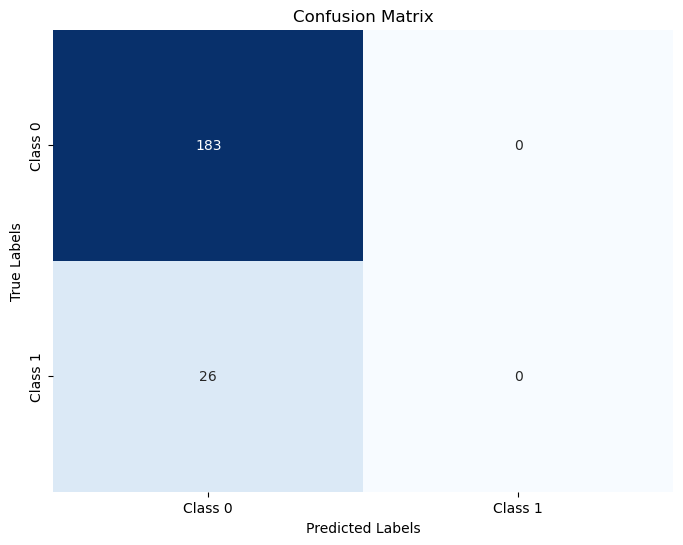

In [85]:
model_test(pipelineN1)

Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.88      1.00      0.93       424
     Class 1       1.00      0.02      0.03        61

    accuracy                           0.88       485
   macro avg       0.94      0.51      0.48       485
weighted avg       0.89      0.88      0.82       485

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       424 |         0 |
+-----------+-----------+
|        60 |         1 |
+-----------+-----------+


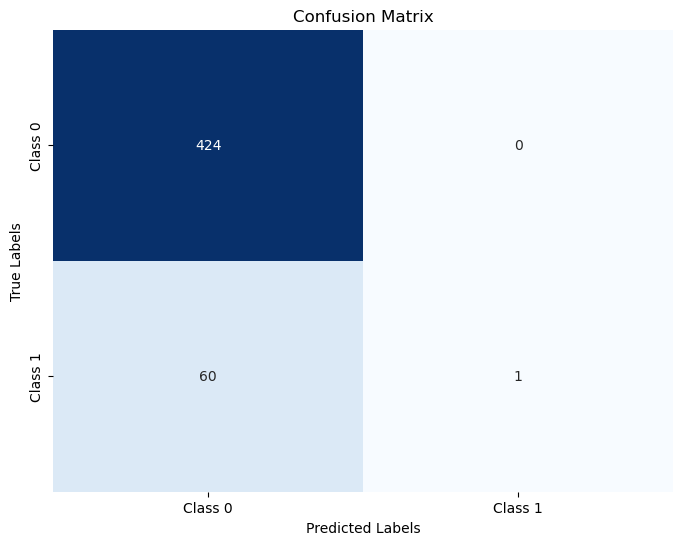

In [86]:
model_test(pipelineN1, X_nt, y_nt)

In [17]:
def pipeline_maker(ov_type, model):
    if ov_type == 'r':
        return Pipeline([('imputer', imputer_r), ('scaler', scaler_r), ('svm', model)])
    if ov_type == 's':
        return Pipeline([('imputer', imputer_s), ('scaler', scaler_s), ('svm', model)])
    if ov_type == 'a':
        return Pipeline([('imputer', imputer_a), ('scaler', scaler_a), ('svm', model)])
    else:
        raise ValueError("Input must be one of 'r', 's' and 'a'.")

In [87]:
param_grid1 = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': list(np.arange(0.1, 1, 0.1)) + ['auto'],  # Adjust the range based on your needs
    'svm__degree': [2, 3, 4],  # Only applicable for 'poly' kernel
}

In [19]:
# RECALL

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best Hyperparameters: {'svm__C': 1, 'svm__degree': 2, 'svm__gamma': 0.9, 'svm__kernel': 'poly'}
Time Taken: 20.373491525650024
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.85      0.88       183
     Class 1       0.25      0.35      0.29        26

    accuracy                           0.79       209
   macro avg       0.58      0.60      0.58       209
weighted avg       0.82      0.79      0.80       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       156 |        27 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


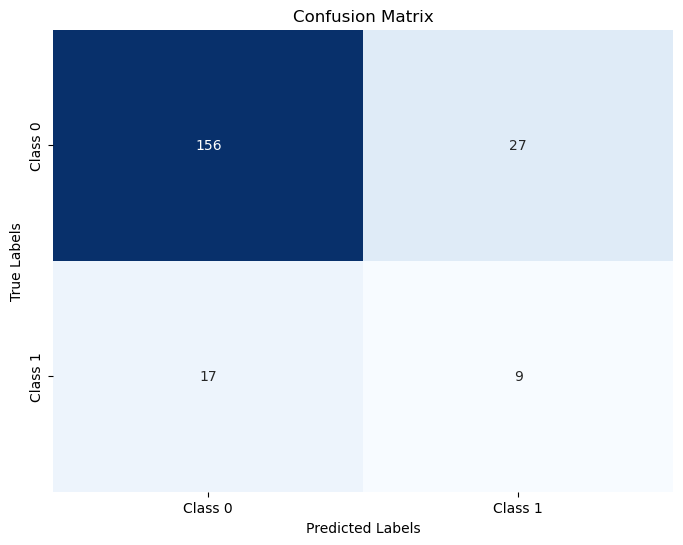

In [88]:
best_paramsN1, best_modelN1 = grid_searcher(param_grid1, pipelineN1)
model_test(best_modelN1)

In [89]:
param_grid1a = {
    'svm__C': [0.1, 0.25, 0.5, 1, 2, 2.5, 4, 5, 8, 10, 20, 25, 40], # 50, 75, 80, 100],
    'svm__kernel': ['linear', 'rbf'], # 'poly'],
    'svm__gamma': list(np.arange(0.1, 1, 0.1)) + ['auto'],  # Adjust the range based on your needs
    'svm__degree': [2, 3, 4],  # Only applicable for 'poly' kernel
}

Fitting 5 folds for each of 780 candidates, totalling 3900 fits
Best Hyperparameters: {'svm__C': 40, 'svm__degree': 2, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Time Taken: 16.95183563232422
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.93      0.92       183
     Class 1       0.37      0.27      0.31        26

    accuracy                           0.85       209
   macro avg       0.63      0.60      0.61       209
weighted avg       0.83      0.85      0.84       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       171 |        12 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


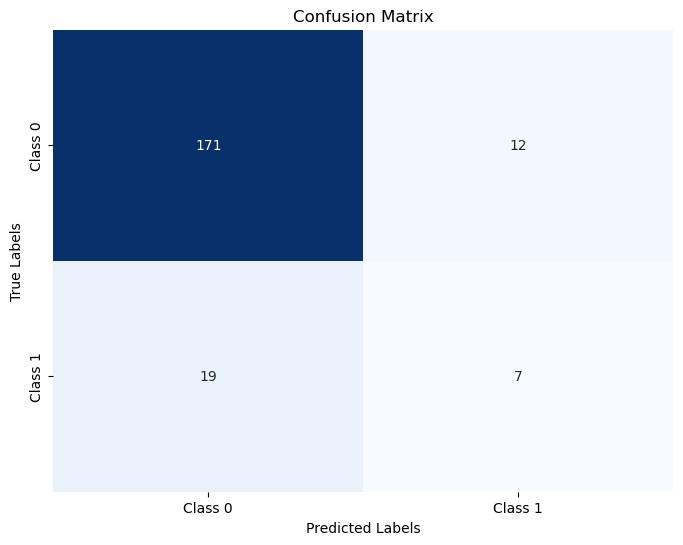

In [90]:
best_paramsN1a, best_modelN1a = grid_searcher(param_grid1a, pipelineN1)
model_test(best_modelN1a)

In [33]:
# MATTHEWS_CORRCOEF

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best Hyperparameters: {'svm__C': 1, 'svm__degree': 2, 'svm__gamma': 0.9, 'svm__kernel': 'poly'}
Time Taken: 11.799764633178711
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.85      0.88       183
     Class 1       0.25      0.35      0.29        26

    accuracy                           0.79       209
   macro avg       0.58      0.60      0.58       209
weighted avg       0.82      0.79      0.80       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       156 |        27 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


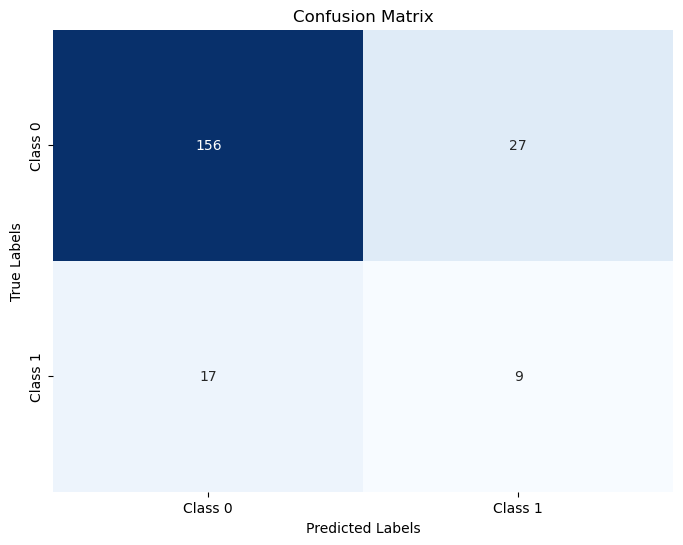

In [91]:
best_paramsN2, best_modelN2 = grid_searcher(param_grid1, pipelineN1, 'matthews_corrcoef')
model_test(best_modelN2)

Fitting 5 folds for each of 780 candidates, totalling 3900 fits
Best Hyperparameters: {'svm__C': 4, 'svm__degree': 2, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Time Taken: 16.37242579460144
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.98      0.93       183
     Class 1       0.50      0.12      0.19        26

    accuracy                           0.88       209
   macro avg       0.69      0.55      0.56       209
weighted avg       0.84      0.88      0.84       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        23 |         3 |
+-----------+-----------+


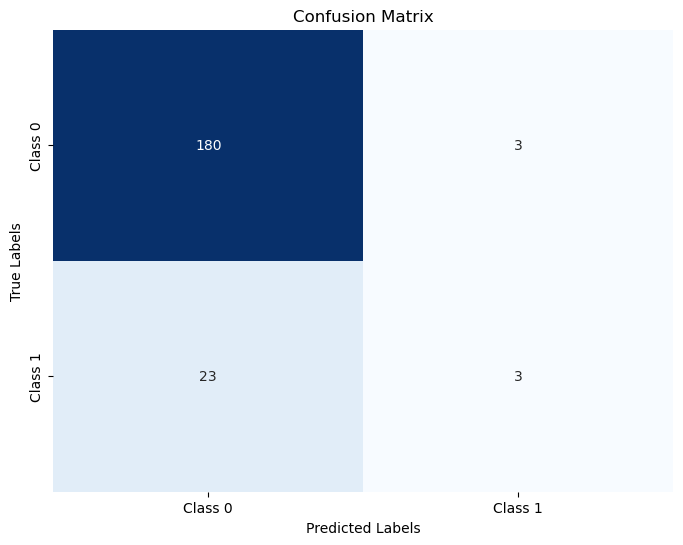

In [92]:
best_paramsN2a, best_modelN2a = grid_searcher(param_grid1a, pipelineN1, 'matthews_corrcoef')
model_test(best_modelN2a)

In [36]:
# F1-SCORE

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best Hyperparameters: {'svm__C': 1, 'svm__degree': 2, 'svm__gamma': 0.9, 'svm__kernel': 'poly'}
Time Taken: 12.272353410720825
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.85      0.88       183
     Class 1       0.25      0.35      0.29        26

    accuracy                           0.79       209
   macro avg       0.58      0.60      0.58       209
weighted avg       0.82      0.79      0.80       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       156 |        27 |
+-----------+-----------+
|        17 |         9 |
+-----------+-----------+


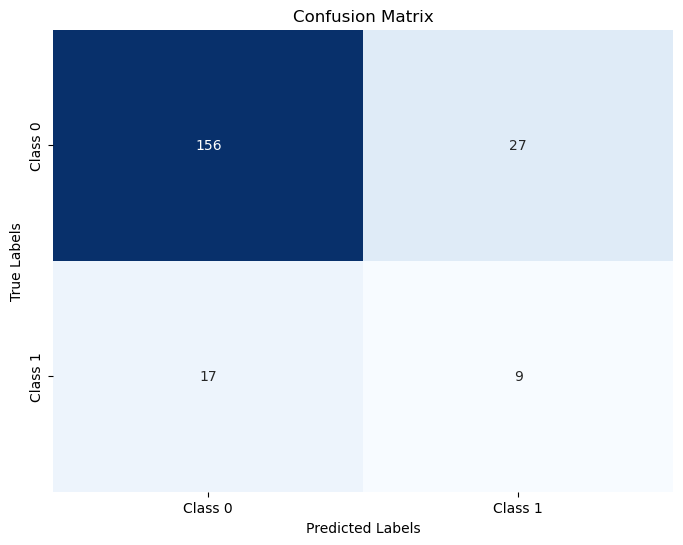

In [93]:
best_paramsN3, best_modelN3 = grid_searcher(param_grid1, pipelineN1, 'f1')
model_test(best_modelN3)

Fitting 5 folds for each of 780 candidates, totalling 3900 fits
Best Hyperparameters: {'svm__C': 40, 'svm__degree': 2, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Time Taken: 16.268062353134155
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.93      0.92       183
     Class 1       0.37      0.27      0.31        26

    accuracy                           0.85       209
   macro avg       0.63      0.60      0.61       209
weighted avg       0.83      0.85      0.84       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       171 |        12 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


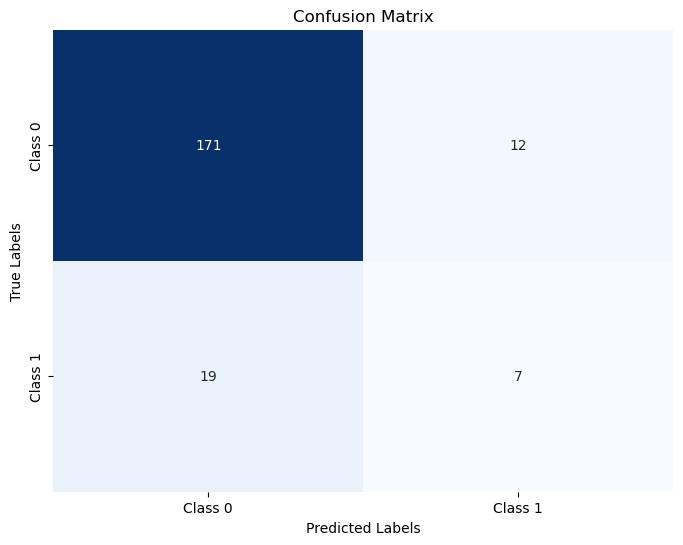

In [94]:
best_paramsN3a, best_modelN3a = grid_searcher(param_grid1a, pipelineN1, 'f1')
model_test(best_modelN3a)

In [95]:
param_grid1a = {
    'svm__C': [0.1, 0.25, 0.5, 1, 2, 2.5, 4, 5, 8, 10, 20, 25, 40, 50, 75, 80, 100],
    'svm__kernel': ['linear', 'rbf'], # 'poly'],
    'svm__gamma': list(np.arange(0.1, 1, 0.1)) + ['auto'],  # Adjust the range based on your needs
    'svm__degree': [2, 3, 4],  # Only applicable for 'poly' kernel
}

Fitting 5 folds for each of 1020 candidates, totalling 5100 fits
Best Hyperparameters: {'svm__C': 80, 'svm__degree': 2, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Time Taken: 30.580566883087158
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.92      0.91       183
     Class 1       0.32      0.27      0.29        26

    accuracy                           0.84       209
   macro avg       0.61      0.59      0.60       209
weighted avg       0.83      0.84      0.83       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       168 |        15 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


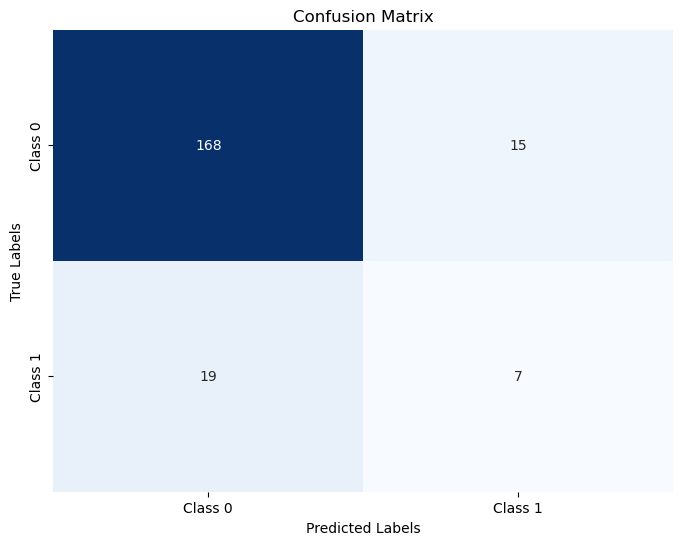

In [96]:
best_paramsN3a, best_modelN3a = grid_searcher(param_grid1a, pipelineN1, 'f1')
model_test(best_modelN3a)

In [97]:
param_grid1ai = {
    'svm__C': [0.1, 1, 10, 25, 50, 100],
    'svm__kernel': ['linear', 'rbf'], #, 'poly'],
    'svm__gamma': list(np.arange(0.1, 1, 0.1)) + ['auto'],  # Adjust the range based on your needs
    # 'svm__degree': [2, 3, 4, 5],  # Only applicable for 'poly' kernel
}

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best Hyperparameters: {'svm__C': 50, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Time Taken: 5.041501998901367
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.93      0.91       183
     Class 1       0.35      0.27      0.30        26

    accuracy                           0.85       209
   macro avg       0.62      0.60      0.61       209
weighted avg       0.83      0.85      0.84       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       170 |        13 |
+-----------+-----------+
|        19 |         7 |
+-----------+-----------+


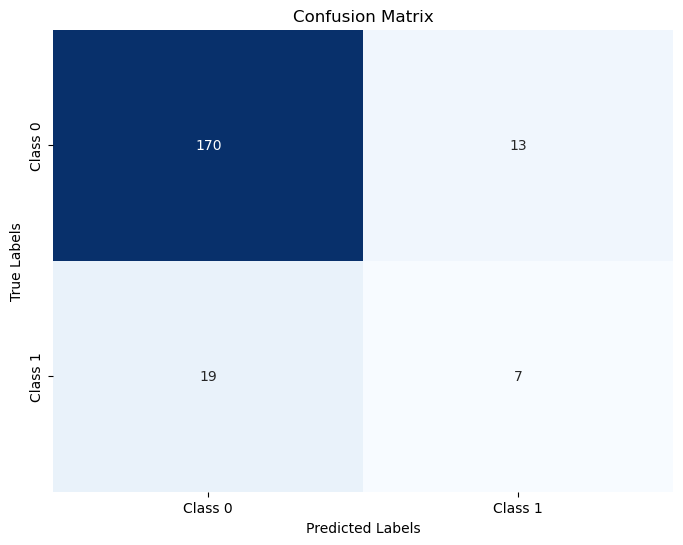

In [98]:
best_paramsN1ai, best_modelN1ai = grid_searcher(param_grid1ai, pipelineN1)
model_test(best_modelN1ai)

In [40]:
# OVERSAMPLED

In [100]:
modelR1 = SVC(random_state = 42)

In [101]:
modelR1.fit(X_nt_ov, y_nt_ov)

SVC(random_state=42)

Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.92      0.83      0.87       183
     Class 1       0.28      0.46      0.35        26

    accuracy                           0.78       209
   macro avg       0.60      0.65      0.61       209
weighted avg       0.84      0.78      0.81       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       152 |        31 |
+-----------+-----------+
|        14 |        12 |
+-----------+-----------+


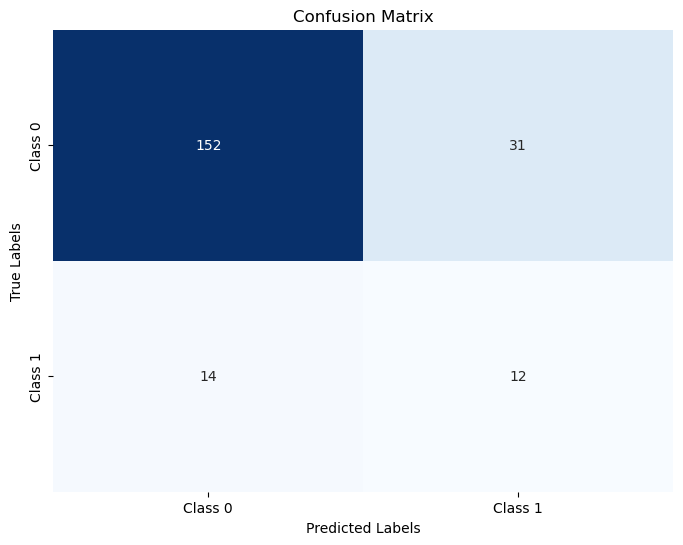

In [102]:
model_test(pipeline_maker("r", modelR1), X_t, y_t)

In [103]:
param_grid1 = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': list(np.arange(0.1, 1, 0.1)) + ['auto'],  # Adjust the range based on your needs
    'svm__degree': [2, 3, 4],  # Only applicable for 'poly' kernel
}

In [110]:
param_grid1a = {
    'svm__C': [0.1, 0.25, 0.5, 1, 2, 2.5, 4, 5, 8, 10, 20, 25, 40], # 50, 75, 80, 100],
    'svm__kernel': ['linear', 'rbf'], # 'poly'],
    'svm__gamma': list(np.arange(0.1, 1, 0.1)) + ['auto'],  # Adjust the range based on your needs
    'svm__degree': [2, 3, 4],  # Only applicable for 'poly' kernel
}

In [105]:
param_grid1ai = {
    'svm__C': [0.1, 1, 10, 25, 50, 100],
    'svm__kernel': ['linear', 'rbf'], #, 'poly'],
    'svm__gamma': list(np.arange(0.1, 1, 0.1)) + ['auto'],  # Adjust the range based on your needs
    # 'svm__degree': [2, 3, 4, 5],  # Only applicable for 'poly' kernel
}

In [59]:
# RECALL

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best Hyperparameters: {'svm__C': 0.1, 'svm__degree': 3, 'svm__gamma': 0.30000000000000004, 'svm__kernel': 'poly'}
Time Taken: 96.91163873672485
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.83      0.86       183
     Class 1       0.24      0.38      0.29        26

    accuracy                           0.77       209
   macro avg       0.57      0.60      0.58       209
weighted avg       0.82      0.77      0.79       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       151 |        32 |
+-----------+-----------+
|        16 |        10 |
+-----------+-----------+


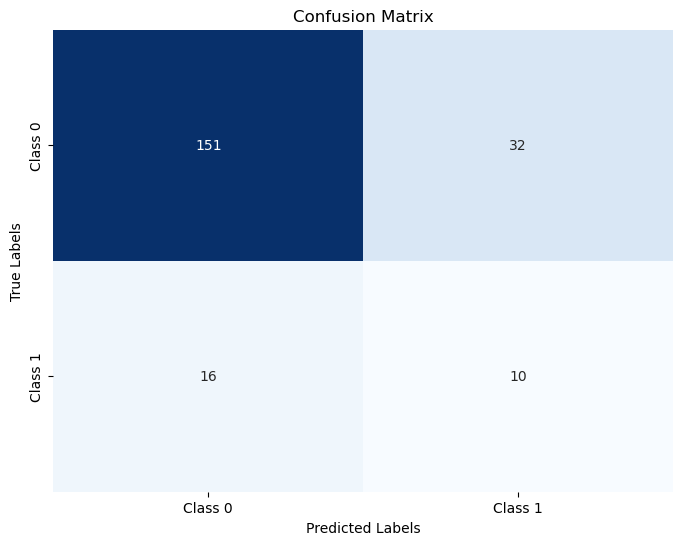

In [107]:
best_paramsR1, best_modelR1 = grid_searcher(param_grid1, Pipeline([('svm', modelR1)]), X_nt = X_nt_ov, y_nt = y_nt_ov)
model_test(pipeline_maker("r", best_modelR1))

Fitting 5 folds for each of 780 candidates, totalling 3900 fits
Best Hyperparameters: {'svm__C': 1, 'svm__degree': 2, 'svm__gamma': 0.4, 'svm__kernel': 'rbf'}
Time Taken: 95.98542499542236
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.98      0.93       183
     Class 1       0.50      0.12      0.19        26

    accuracy                           0.88       209
   macro avg       0.69      0.55      0.56       209
weighted avg       0.84      0.88      0.84       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        23 |         3 |
+-----------+-----------+


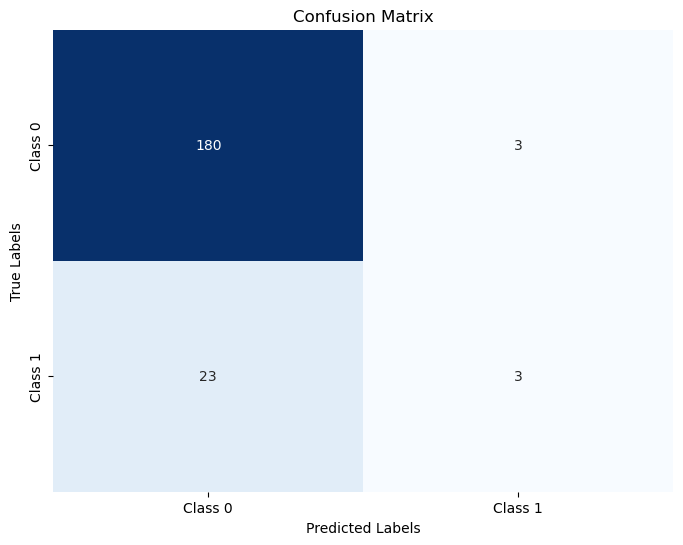

In [111]:
best_paramsR1, best_modelR1 = grid_searcher(param_grid1a, Pipeline([('svm', modelR1)]), X_nt = X_nt_ov, y_nt = y_nt_ov)
model_test(pipeline_maker("r", best_modelR1))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best Hyperparameters: {'svm__C': 1, 'svm__gamma': 0.4, 'svm__kernel': 'rbf'}
Time Taken: 45.86376214027405
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.98      0.93       183
     Class 1       0.50      0.12      0.19        26

    accuracy                           0.88       209
   macro avg       0.69      0.55      0.56       209
weighted avg       0.84      0.88      0.84       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       180 |         3 |
+-----------+-----------+
|        23 |         3 |
+-----------+-----------+


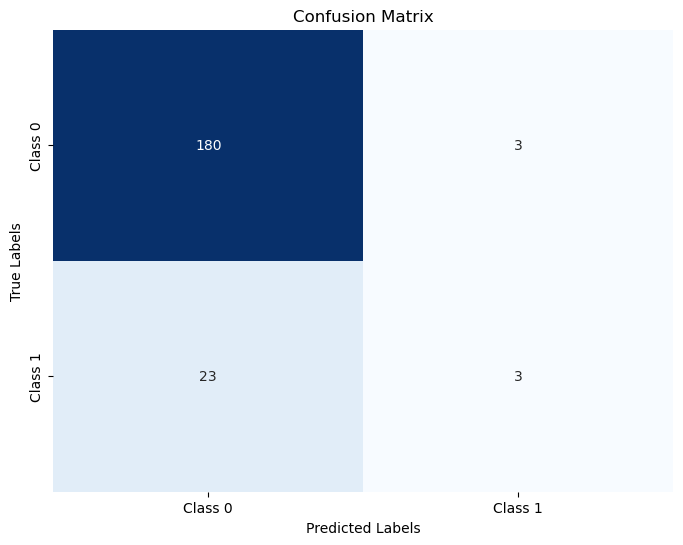

In [112]:
best_paramsR1, best_modelR1 = grid_searcher(param_grid1ai, Pipeline([('svm', modelR1)]), X_nt = X_nt_ov, y_nt = y_nt_ov)
model_test(pipeline_maker("r", best_modelR1))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best Hyperparameters: {'svm__C': 50, 'svm__degree': 3, 'svm__kernel': 'poly'}
Time Taken: 25.17276620864868
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.91      0.83      0.87       183
     Class 1       0.26      0.42      0.32        26

    accuracy                           0.78       209
   macro avg       0.59      0.63      0.60       209
weighted avg       0.83      0.78      0.80       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       152 |        31 |
+-----------+-----------+
|        15 |        11 |
+-----------+-----------+


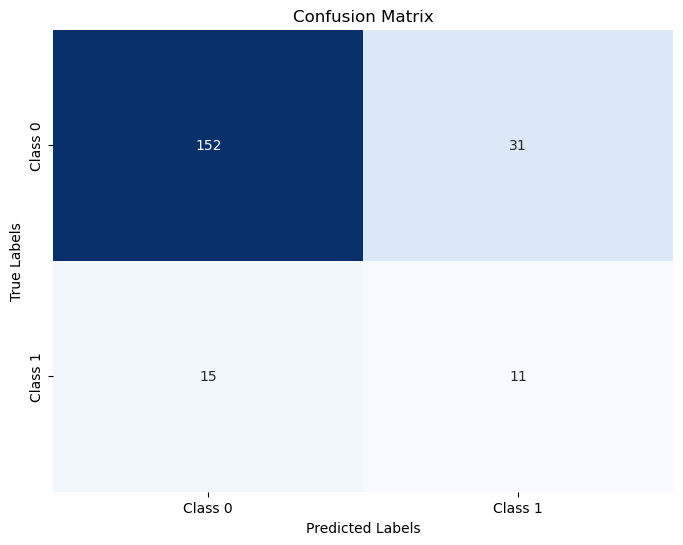

In [113]:
best_paramsR1a, best_modelR1a = grid_searcher(param_gridR1a, Pipeline([('svm', modelR1)]), X_nt = X_nt_ov, y_nt = y_nt_ov)
model_test(pipeline_maker("r", best_modelR1a))

In [114]:
# MATTHEWS_CORRCOEF

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best Hyperparameters: {'svm__C': 1, 'svm__degree': 2, 'svm__gamma': 0.8, 'svm__kernel': 'rbf'}
Time Taken: 89.39523649215698
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.87      0.99      0.93       183
     Class 1       0.00      0.00      0.00        26

    accuracy                           0.87       209
   macro avg       0.44      0.49      0.46       209
weighted avg       0.77      0.87      0.81       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       181 |         2 |
+-----------+-----------+
|        26 |         0 |
+-----------+-----------+


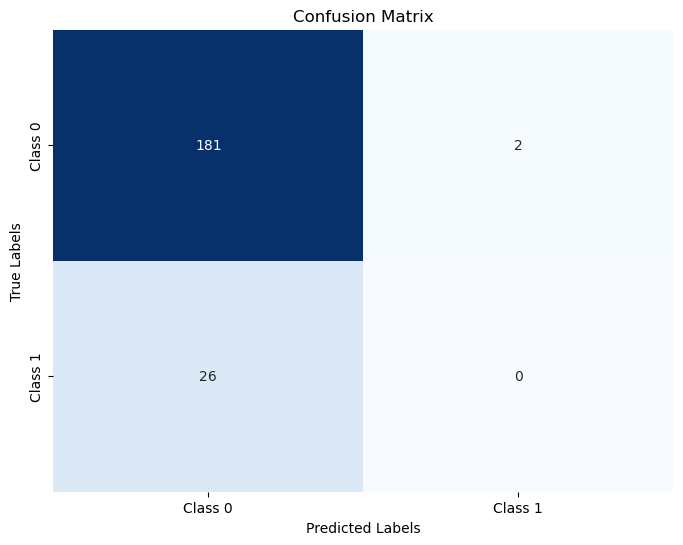

In [115]:
best_paramsR1, best_modelR1 = grid_searcher(param_grid1, Pipeline([('svm', modelR1)]), X_nt = X_nt_ov, y_nt = y_nt_ov, scoring = "matthews_corrcoef")
model_test(pipeline_maker("r", best_modelR1))

Fitting 5 folds for each of 780 candidates, totalling 3900 fits
Best Hyperparameters: {'svm__C': 1, 'svm__degree': 2, 'svm__gamma': 0.8, 'svm__kernel': 'rbf'}
Time Taken: 99.17370057106018
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.87      0.99      0.93       183
     Class 1       0.00      0.00      0.00        26

    accuracy                           0.87       209
   macro avg       0.44      0.49      0.46       209
weighted avg       0.77      0.87      0.81       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       181 |         2 |
+-----------+-----------+
|        26 |         0 |
+-----------+-----------+


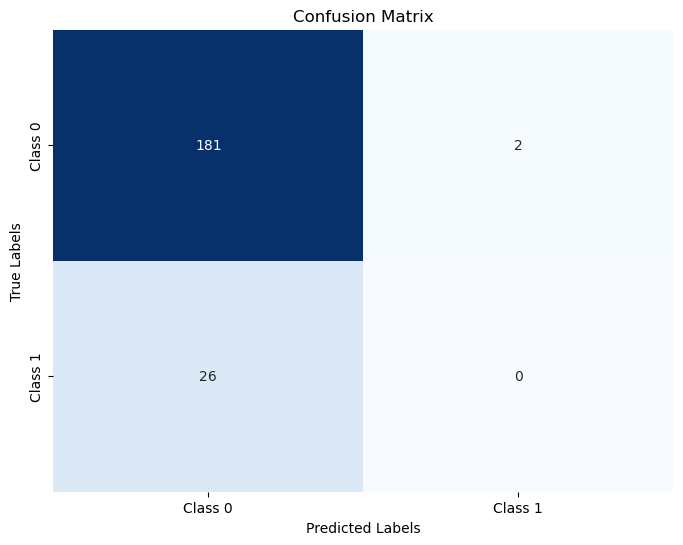

In [116]:
best_paramsR1, best_modelR1 = grid_searcher(param_grid1a, Pipeline([('svm', modelR1)]), X_nt = X_nt_ov, y_nt = y_nt_ov, scoring = "matthews_corrcoef")
model_test(pipeline_maker("r", best_modelR1))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best Hyperparameters: {'svm__C': 1, 'svm__gamma': 0.8, 'svm__kernel': 'rbf'}
Time Taken: 47.626402854919434
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.87      0.99      0.93       183
     Class 1       0.00      0.00      0.00        26

    accuracy                           0.87       209
   macro avg       0.44      0.49      0.46       209
weighted avg       0.77      0.87      0.81       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       181 |         2 |
+-----------+-----------+
|        26 |         0 |
+-----------+-----------+


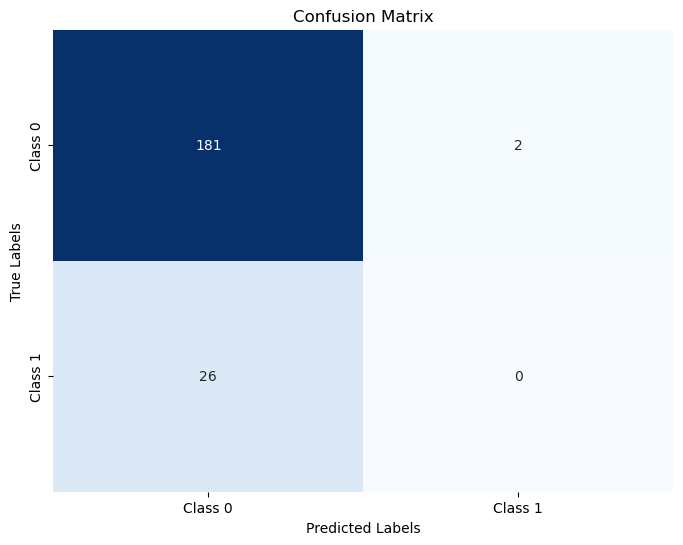

In [117]:
best_paramsR1, best_modelR1 = grid_searcher(param_grid1ai, Pipeline([('svm', modelR1)]), X_nt = X_nt_ov, y_nt = y_nt_ov, scoring = "matthews_corrcoef")
model_test(pipeline_maker("r", best_modelR1))

In [118]:
param_gridR1a = {
    'svm__C': [0.001, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1, 5, 10, 50, 100],
    'svm__kernel': ['linear', 'poly'], # 'rbf'],
    # 'svm__gamma': list(np.arange(0.1, 1, 0.1)) + ['auto'],  # Adjust the range based on your needs
    'svm__degree': [2, 3, 4, 5, 6],  # Only applicable for 'poly' kernel
}

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best Hyperparameters: {'svm__C': 100, 'svm__degree': 4, 'svm__kernel': 'poly'}
Time Taken: 25.138240814208984
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.89      0.89       183
     Class 1       0.23      0.23      0.23        26

    accuracy                           0.81       209
   macro avg       0.56      0.56      0.56       209
weighted avg       0.81      0.81      0.81       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       163 |        20 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


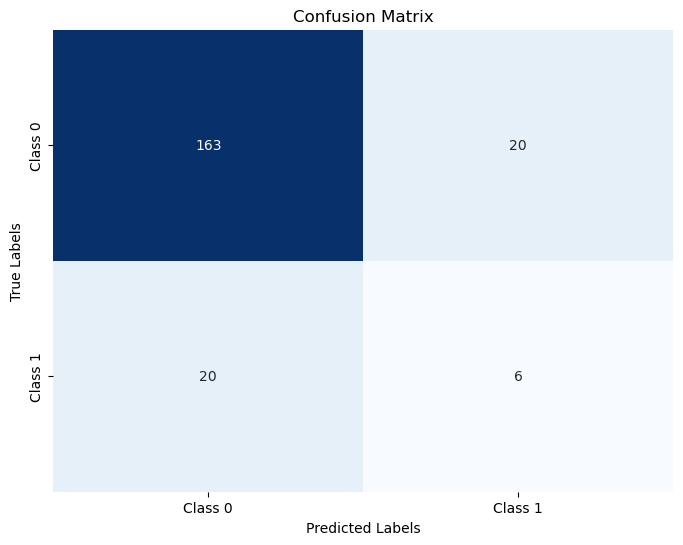

In [119]:
best_paramsR1, best_modelR1 = grid_searcher(param_gridR1a, Pipeline([('svm', modelR1)]), X_nt = X_nt_ov, y_nt = y_nt_ov, scoring = "matthews_corrcoef")
model_test(pipeline_maker("r", best_modelR1))

In [120]:
# F1

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best Hyperparameters: {'svm__C': 1, 'svm__degree': 2, 'svm__gamma': 0.8, 'svm__kernel': 'rbf'}
Time Taken: 90.25039219856262
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.87      0.99      0.93       183
     Class 1       0.00      0.00      0.00        26

    accuracy                           0.87       209
   macro avg       0.44      0.49      0.46       209
weighted avg       0.77      0.87      0.81       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       181 |         2 |
+-----------+-----------+
|        26 |         0 |
+-----------+-----------+


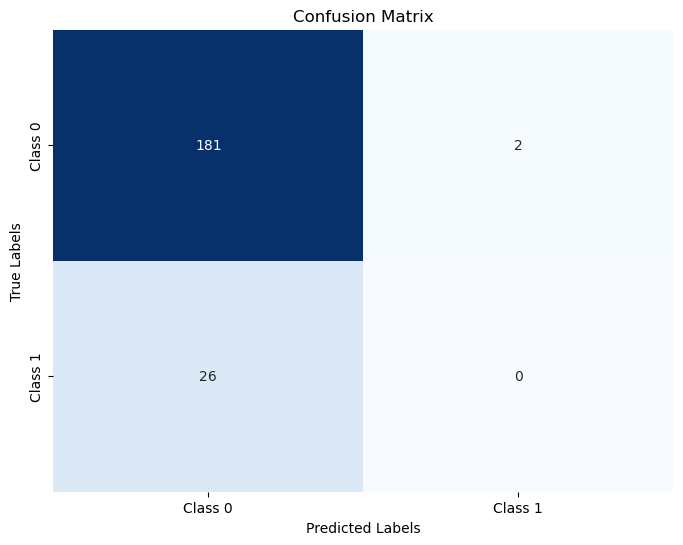

In [121]:
best_paramsR2, best_modelR2 = grid_searcher(param_grid1, Pipeline([('svm', modelR1)]), X_nt = X_nt_ov, y_nt = y_nt_ov, scoring = 'f1')
model_test(pipeline_maker("r", best_modelR2))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best Hyperparameters: {'svm__C': 100, 'svm__degree': 4, 'svm__kernel': 'poly'}
Time Taken: 25.042580127716064
Classification Report on Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.89      0.89       183
     Class 1       0.23      0.23      0.23        26

    accuracy                           0.81       209
   macro avg       0.56      0.56      0.56       209
weighted avg       0.81      0.81      0.81       209

Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       163 |        20 |
+-----------+-----------+
|        20 |         6 |
+-----------+-----------+


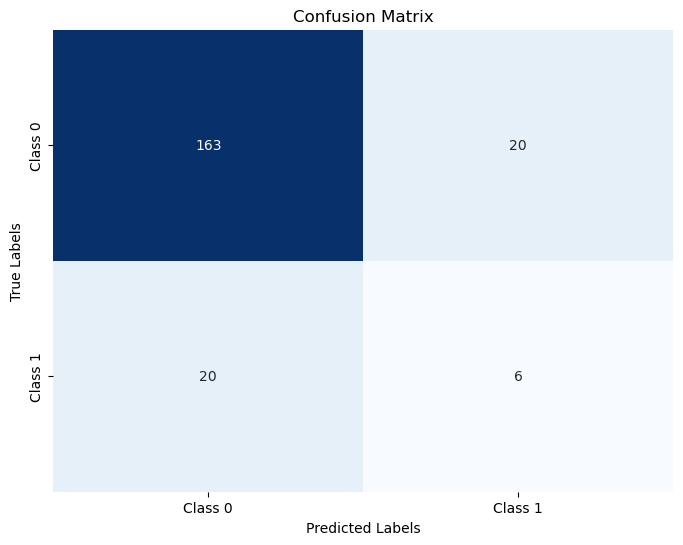

In [122]:
best_paramsR2a, best_modelR2a = grid_searcher(param_gridR1a, Pipeline([('svm', modelR1)]), X_nt = X_nt_ov, y_nt = y_nt_ov, scoring = 'jaccard')
model_test(pipeline_maker("r", best_modelR2a))